# Импорт библиотек

In [1]:
import cv2
import numpy as np

In [2]:
# constants
INPUT_HEIGHT = 640
INPUT_WIDTH = 640
SCORE_TRESHOLD = 0.5
NMS_THRESHOLD = 0.45
CONFIDENCE_THRESHOLD = 0.45
# text parametres
FONT_FACE = cv2.FONT_HERSHEY_SIMPLEX
FONT_SCALE = 0.7
THICKNESS = 1
# colors
BLACK = (0,0,0)
BLUE = (255,178,50)
YELLOW = (0,255,255)

# функции обработки изображений

In [3]:
def draw_label(input_image, label, left, top):
    # get text size
    text_size = cv2.getTextSize(label, FONT_FACE, FONT_SCALE, THICKNESS)
    dim, baseline = text_size[0], text_size[1]

    # use text size to create a black rectangle
    cv2.rectangle(input_image, (left, top), (left + dim[0], top + dim[1] + baseline), (0,0,0), cv2.FILLED)

    # display text inside the rectangle
    cv2.putText(input_image, label, (left, top + dim[1]), FONT_FACE, FONT_SCALE, YELLOW, THICKNESS, cv2.LINE_AA)

def draw_label_above(input_image, label, left, top):
    # Get text size
    text_size = cv2.getTextSize(label, FONT_FACE, FONT_SCALE, THICKNESS)
    dim, baseline = text_size[0], text_size[1]

    # Calculate the top-left and bottom-right points of the rectangle
    bottom_right = (left + dim[0], top)  # Bottom-right of rectangle is at the top of the specified point
    top_left = (left, top - dim[1] - baseline)  # Top-left of rectangle is above the point

    # Draw a black rectangle for the label background
    cv2.rectangle(input_image, top_left, bottom_right, (0, 0, 0), cv2.FILLED)

    # Draw the text inside the rectangle
    cv2.putText(input_image, label, (left, top - baseline), FONT_FACE, FONT_SCALE, YELLOW, THICKNESS, cv2.LINE_AA)
    

In [4]:
def resize_with_aspect_ratio(image, target_size=(640, 640), padding_color=(0, 0, 0)):
    """
    Изменяет размер изображения с сохранением пропорций и добавлением отступов.
    
    :param image: Исходное изображение (numpy array).
    :param target_size: Кортеж (width, height), к которому нужно привести изображение.
    :param padding_color: Цвет отступов (по умолчанию черный).
    :return: Измененное изображение с отступами.
    """
    # Исходные размеры
    h, w = image.shape[:2]
    target_width, target_height = target_size
    global scale
    # Рассчитываем соотношения
    scale = min(target_width / w, target_height / h)
    new_w = int(w * scale)
    new_h = int(h * scale)

    # Изменение размера с сохранением пропорций
    resized_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC)

    # Создаем пустое изображение с цветом фона
    result = np.full((target_height, target_width, 3), padding_color, dtype=np.uint8)

    global x_offset, y_offset
    # Вставляем измененное изображение в центр
    x_offset = (target_width - new_w) // 2
    y_offset = (target_height - new_h) // 2
    result[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized_image

    return result

In [5]:
def pre_process(input_img, net):
    blob = cv2.dnn.blobFromImage(image=input_img, scalefactor=1/255, size=(INPUT_HEIGHT, INPUT_WIDTH), mean=[0,0,0], swapRB=True, crop=False)
    net.setInput(blob)
    outputs = net.forward(net.getUnconnectedOutLayersNames())
    return outputs

In [6]:
def pre_process2(input_img, net):
    """
    данная функция преобразует входное изображение в формат, испльзуемый в YOLO
    и выполняет детекцию классов
    """
    new_input_img=resize_with_aspect_ratio(input_img)
    blob = cv2.dnn.blobFromImage(image=new_input_img, scalefactor=1/255, size=(INPUT_HEIGHT, INPUT_WIDTH), mean=[0,0,0], swapRB=True, crop=False)
    net.setInput(blob)
    outputs = net.forward(net.getUnconnectedOutLayersNames())
    return outputs

In [7]:
def post_process_and_box(input_img, outputs, classes):
    """
    функция идентична функции post_process
    добавлен дополнительный объект, который возвращает функция (координаты bbox показаний счетчика - indications_box)
    indications_box - будет использован при вырезки показаний счетчика для детектирования каждой цифры
    """
    
    # lists to hold respective values while unwrapping
    class_ids = []
    confidences = []
    boxes = []

    # get image parametres
    image_height, image_width = input_img.shape[:2]
    x_factor = image_width / INPUT_WIDTH
    y_factor = image_height / INPUT_HEIGHT
    
    # drop garbage and transpose outputs
    outputs = outputs[0][0]
    outputs = outputs.transpose()
    # now we got outputs.shape = (8400, 6)

    # keep rows with scores > confidence_tereshold
    rows = [row for row in outputs if any(row[4:] > SCORE_TRESHOLD)]
    for row in rows:
        class_id = np.argmax(row[4:])
        confidences.append(row[4:][class_id])
        class_ids.append(class_id)
        xc, yc, w, h = row[:4]
        left = int((xc - w/2) * x_factor)
        top = int((yc - h/2) * y_factor)
        width = int(w * x_factor)
        height = int(h * y_factor)
        box = np.array([left, top, width, height])
        boxes.append(box)

    # perform nms
    indices = cv2.dnn.NMSBoxes(boxes, confidences, SCORE_TRESHOLD, NMS_THRESHOLD)
    for i in indices:
        box = boxes[i]
        left, top, width, height = box
        # print(box)
        # draw bbox
        cv2.rectangle(input_img, (left, top), (left + width, top + height), BLUE, 3*THICKNESS)

        # class labels
        # label = "{}:{:.2f}".format(classes[class_ids[i]], confidences[i])
        label = "{}".format(classes[class_ids[i]], confidences[i])
        
        # draw label
        if 'indications' not in label:
            draw_label(input_img, label, left, top)

        # get box of indications
        if classes[class_ids[i]] == 'indications':
            indications_box = box
            
    if 'indications' in classes:
        if indications_box is None:
            print('indications are not detected')
        else:
            return input_img, indications_box
    else:
        return input_img
    

In [8]:
def get_crop(img, box):
    """
    функция для вырезания области индикаций в изображении
    """
    
    left, top, width, height = box
    # crop_img = img[top-20: top+height+20, left-30:left+width+30]
    crop_img = img[top: top+height, left:left+width]
    return crop_img

In [9]:
def add_bboxes(input_img, cropped_img, outputs, classes, indications_box):
    """
    функция доработанная от post_processing
    принимает оригинальное изображение и вырезанное, с предсказаниями для вырезанного изображения
    рисует детекцию с учетом размеров оригинального изображения 
    """
    
    # lists to hold respective values while unwrapping
    class_ids = []
    confidences = []
    boxes = []
    bias_left, bias_top, bias_width, bias_height = indications_box
    # get image parametres
    image_height, image_width = cropped_img.shape[:2]
    x_factor = image_width / INPUT_WIDTH
    y_factor = image_height / INPUT_HEIGHT
    print(f'scale factors: x:{x_factor}, y:{y_factor}')
    # x_factor=1
    # y_factor=1

    
    # drop garbage and transpose outputs
    outputs = outputs[0][0]
    outputs = outputs.transpose()
    # now we got outputs.shape = (8400, 6)

    # keep rows with scores > confidence_tereshold
    rows = [row for row in outputs if any(row[4:] > SCORE_TRESHOLD)]
    for row in rows:
        class_id = np.argmax(row[4:])
        confidences.append(row[4:][class_id])
        class_ids.append(class_id)
        xc, yc, w, h = row[:4]
        left = int((xc - w/2) / scale) + bias_left - int(x_offset/scale)
        top = int((yc - h/2) / scale) + bias_top - int(y_offset/scale)
        
        width = int(w / scale)
        height = int(h / scale)
        box = np.array([left, top, width, height])
        boxes.append(box)

    # perform nms
    indices = cv2.dnn.NMSBoxes(boxes, confidences, SCORE_TRESHOLD, NMS_THRESHOLD)
    for i in indices:
        box = boxes[i]
        left, top, width, height = box
        # print(box)
        # draw bbox
        cv2.rectangle(input_img, (left, top), (left + width, top + height), BLUE, 1*THICKNESS)

        # class labels
        # label = "{}:{:.2f}".format(classes[class_ids[i]], confidences[i])
        label = "{}".format(classes[class_ids[i]])
        # draw label
        draw_label_above(input_img, label, left, top)

    return input_img

# cv2.dnn inference 

In [15]:
if __name__ == '__main__':
    classesFile = r"D:\Magistratura_3_semestr\Neironki\classes.txt"
    classes = None
    with open(classesFile, "rt") as f:
        classes = f.read().rstrip("\n").split("\n")
    frame = cv2.imread(r"D:\Magistratura_3_semestr\id_446_value_271_545.jpg")
    
    modelWeights = r"D:\Jupyter_Notebook\kgeu_abdullin\runs\train\yolov5n_exp14\weights\best.onnx"
    net = cv2.dnn.readNet(modelWeights)

    detections = pre_process(frame, net)
    img, indications_box = post_process_and_box(frame.copy(), detections, classes)

    
    classesFile2 = r"D:\Jupyter_Notebook\kgeu_abdullin\runs\train\yolov5n_exp1_googlecolab\classes.txt"
    classes2 = None
    with open(classesFile2, "rt") as f:
        classes2 = f.read().rstrip("\n").split("\n")
    modelWeights2 = r"D:\Jupyter_Notebook\kgeu_abdullin\lab09\runs\train\yolov5nu_svhn_exp\weights\best.onnx"
    # modelWeights2 = r"D:\Jupyter_Notebook\kgeu_abdullin\lab09\runs\train\yolov5n_quantized.onnx"
    net2 = cv2.dnn.readNet(modelWeights2)
    cropped_img = get_crop(frame.copy(), indications_box) 
    detections2 = pre_process2(cropped_img, net2)
    img2 = add_bboxes(img.copy(), cropped_img.copy(),detections2, classes2, indications_box)

    """
    Put efficiency information. The function getPerfProfile returns the overall time for inference(t)
    and the timings for each of the layers(in layersTimes).
    """
    t, _ = net.getPerfProfile()
    label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
    print(label)
    cv2.putText(img2, label, (20, 40), FONT_FACE, FONT_SCALE, (0,0,255), THICKNESS, cv2.LINE_AA)

    t2, _ = net2.getPerfProfile()
    label2 = 'Inference time: %.2f ms' % (t2 * 1000.0 / cv2.getTickFrequency())
    print(label2)
    cv2.putText(img2, label2, (20, 60), FONT_FACE, FONT_SCALE, (0,0,255), THICKNESS, cv2.LINE_AA)
    
    cv2.imshow('output', img2)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

scale factors: x:0.7453125, y:0.1578125
Inference time: 74.66 ms
Inference time: 98.82 ms


In [11]:
import matplotlib.pyplot as plt

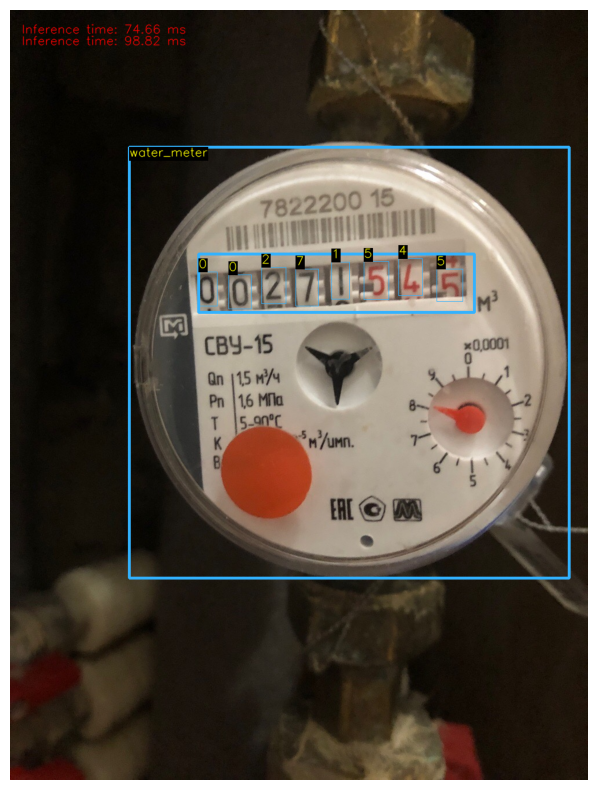

In [16]:
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(img2_rgb)

- инференс на другом фото

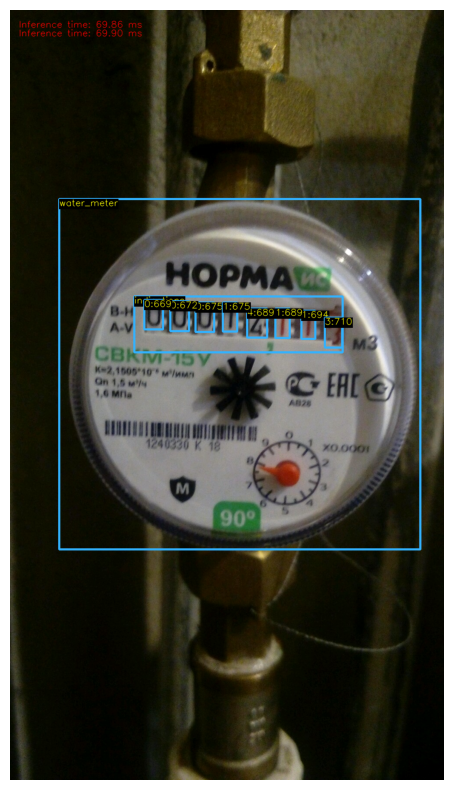

In [58]:
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(img2_rgb)